# Linear Systems Solver with Iterative Methods

This notebook implements iterative methods for solving linear systems, specifically focusing on:

1. **Jacobi Iteration Method** - An iterative method for solving systems of linear equations
2. **2D Poisson Equation** - Discrete Laplacian operator on a 2D grid
3. **LU Factorization** - Direct method for comparison with iterative approaches

## Key Components:
- Matrix splitting for Jacobi method (A = D + L + U)
- Sparse matrix operations for efficiency
- Convergence checking with multiple criteria
- 2D Poisson matrix generation with proper boundary conditions
- Performance analysis and operation counting

## Applications:
- Solving partial differential equations on grids
- Image processing and computer graphics
- Scientific computing and numerical analysis

In [1]:
import numpy as np
#numpy4lyfe

Below are the matrix operations required to perform Jacobi iteration.
Methods:
    - split:
        Splits a given numpy matrix A and stores a sparsely stored matrix without diagonals
        in a_zero and a 1D array of diagonals in d
    - check_error:
        Finds the maximum difference in magnitude between entries of Axk (current solution estimate)
        and b (solution). Returns 1 if this maximum difference in less than a given error tolerance eps,
        0 otherwise
    - a_x:
        Performs matrix-vector multiplication between a matrix A (given as parameters a_zero and d) and vector 
        v and returns resulting vector. Effectively performs (a_zero + d)v, which is equivalent to 
        Av
    - a_zero_x:
        Performs matrix-vector multiplication between a sparse matrix a_zero and a vector v, returning
        the resulting vector
    - d_inv_x: 
        Performs matrix-vector multiplication between a diagonal matrix d (inversed) and a vector v, returning
        the resulting vector


In [2]:

# Splits a nxn matrix into a diagonal matrix D with only diagonal elements of A and a matrix A0 with zeros on the diagonal
#split A into A and D
def split(a_zero, d, A):
    n = len(A)
    for i in range(n):
        curr_row = []
        for j in range(n):
            if((i != j)):
                if((A[i][j] != 0)):
                    curr_row.append((j, A[i][j]))
            else:
                d.append(A[i][j])
        a_zero.append(curr_row)
    return


def check_error(v, b, eps, a_zero, d):
    A_x = a_x(v, a_zero, d)
    abs_mat = np.abs(A_x - b)
    e = np.max(abs_mat)
    if(e < eps):
        return 1
    return 0


def a_x(v, a_zero, d):
    n = len(a_zero)
    result = np.zeros(n)
    for i in range(n):
        result[i] = (d[i] * v[i])
    result = result + a_zero_x(v, a_zero)  
    return result

def a_zero_x(v, a_zero):
    n = len(a_zero)
    result = np.zeros(n)
    for i in range(n):
        for j in range(len(a_zero[i])):
            result[i] += a_zero[i][j][1] * v[a_zero[i][j][0]]
    return result


def d_inv_x(v, d):
    n = len(d)
    result = np.zeros(n)
    for i in range(n):
        result[i] = (1.0/d[i] * v[i])
    return result   


Below is a method that performs the jacobi algorithm for a given matrix A, a starting vector x, a 
solution vector b, and a given error tolerance eps.

In [3]:
def jacobi_algorithm(A, x, b, eps, max_iter=1000):
    iteration = 0
    x = np.array(x, dtype=float)
    b = np.array(b, dtype=float)
    a_zero_mat = []
    d = []
    split(a_zero_mat, d, A)
    
    # Check if diagonal elements are non-zero
    if any(abs(di) < 1e-14 for di in d):
        print("Warning: Matrix has zero or near-zero diagonal elements")
        return x
    
    prev_x = x.copy()
    
    while iteration < max_iter:
        # Check convergence before updating
        if iteration > 0 and check_error(x, b, eps, a_zero_mat, d):
            break
            
        A0x = a_zero_x(x, a_zero_mat)
        b_minus_A0x = b - A0x
        x = d_inv_x(b_minus_A0x, d)
        
        # Additional convergence check: relative change in solution
        if iteration > 0:
            rel_change = np.linalg.norm(x - prev_x) / (np.linalg.norm(x) + 1e-14)
            if rel_change < eps:
                print(f"Converged due to small relative change: {rel_change}")
                break
        
        prev_x = x.copy()
        iteration += 1
    
    if iteration >= max_iter:
        print(f"Warning: Maximum iterations ({max_iter}) reached without convergence")
    else:
        print(f"Converged in {iteration} iterations")
    
    return x

Below defines an algorithm to create and return a 2D poisson matrix with a given parameter N.

In [4]:
#Generate 2D Poisson matrix with proper boundary conditions
def poisson_2d(N):
    A = np.zeros((N*N, N*N))
    for i in range(N*N):
        row = i // N  # row index in 2D grid
        col = i % N   # column index in 2D grid
        
        A[i][i] = -4  # diagonal element
        
        # Right neighbor (same row, next column)
        if col < N-1:
            A[i][i+1] = 1
        
        # Left neighbor (same row, previous column)  
        if col > 0:
            A[i][i-1] = 1
            
        # Bottom neighbor (next row, same column)
        if row < N-1:
            A[i][i+N] = 1
            
        # Top neighbor (previous row, same column)
        if row > 0:
            A[i][i-N] = 1
            
    return A

Below defines an algorithm for LU factorization based on Lay's textbook (chapter 2.5). Returns L as L and U as A.
Prints non-zero entries in result L and U as well as number of operations required for LU factorization.

In [5]:
#LU factorization with proper Gaussian elimination
def poisson_LU(n):
    ops = 0
    A = poisson_2d(n)
    size = n * n
    L = np.eye(size)  # Initialize L as identity matrix
    U = A.copy()      # U will be the upper triangular result
    
    for k in range(size-1):
        for i in range(k+1, size):
            if U[k][k] != 0:  # Check for non-zero pivot
                factor = U[i][k] / U[k][k]
                L[i][k] = factor
                ops += 1
                
                # Eliminate column k in row i
                for j in range(k, size):
                    U[i][j] = U[i][j] - factor * U[k][j]
                    ops += 2  # one multiplication, one subtraction
    
    # Count non-zero elements
    nonzeroL = np.count_nonzero(L)
    nonzeroU = np.count_nonzero(U)
    
    print(f"Poisson matrix size {n}x{n} ({size}x{size}): L has {nonzeroL} non-zero entries, U has {nonzeroU}")
    print(f"LU factorization took approximately {ops} operations")
    
    return L, U


In [6]:
for i in range(1,16):
    poisson_LU(i)

Poisson matrix size 1x1 (1x1): L has 1 non-zero entries, U has 1
LU factorization took approximately 0 operations
Poisson matrix size 2x2 (4x4): L has 9 non-zero entries, U has 9
LU factorization took approximately 46 operations
Poisson matrix size 3x3 (9x9): L has 29 non-zero entries, U has 29
LU factorization took approximately 516 operations
Poisson matrix size 4x4 (16x16): L has 67 non-zero entries, U has 71
LU factorization took approximately 2840 operations
Poisson matrix size 5x5 (25x25): L has 129 non-zero entries, U has 137
LU factorization took approximately 10700 operations
Poisson matrix size 6x6 (36x36): L has 221 non-zero entries, U has 234
LU factorization took approximately 31710 operations
Poisson matrix size 7x7 (49x49): L has 349 non-zero entries, U has 370
LU factorization took approximately 79576 operations
Poisson matrix size 8x8 (64x64): L has 519 non-zero entries, U has 560
LU factorization took approximately 176736 operations
Poisson matrix size 9x9 (81x81): L 

In [7]:
#question 6 - Test Jacobi algorithm with point source in center
def q6(n):
    b = np.zeros(n**2)
    # Place unit source at center of grid
    center_idx = n * (n // 2) + (n // 2)
    b[center_idx] = 1
    return b

print("Testing Jacobi algorithm on 2D Poisson equations:")
print("=" * 50)

# Test with smaller matrices first to ensure convergence
test_sizes = [3, 5, 7, 10]

for n in test_sizes:
    print(f"\nTesting with {n}x{n} grid ({n**2}x{n**2} matrix):")
    
    A = poisson_2d(n)
    x = np.zeros(n**2)
    b = q6(n)
    eps = 1e-8  # More reasonable tolerance
    
    # Check if matrix is diagonally dominant (important for Jacobi convergence)
    diag_dominant = True
    for i in range(n**2):
        row_sum = sum(abs(A[i][j]) for j in range(n**2) if i != j)
        if abs(A[i][i]) <= row_sum:
            diag_dominant = False
            break
    
    print(f"Matrix is diagonally dominant: {diag_dominant}")
    
    try:
        result = jacobi_algorithm(A, x, b, eps, max_iter=2000)
        
        # Verify solution quality
        residual = np.linalg.norm(A @ result - b)
        print(f"Final residual norm: {residual:.2e}")
        
        if residual < 1e-6:
            print("✓ Solution appears accurate")
        else:
            print("⚠ Solution may not be accurate")
            
    except Exception as e:
        print(f"Error during computation: {e}")
    
    print("-" * 30)


Testing Jacobi algorithm on 2D Poisson equations:

Testing with 3x3 grid (9x9 matrix):
Matrix is diagonally dominant: False
Converged in 51 iterations
Final residual norm: 1.49e-08
✓ Solution appears accurate
------------------------------

Testing with 5x5 grid (25x25 matrix):
Matrix is diagonally dominant: False
Converged due to small relative change: 9.854959082919638e-09
Converged in 116 iterations
Final residual norm: 2.31e-08
✓ Solution appears accurate
------------------------------

Testing with 7x7 grid (49x49 matrix):
Matrix is diagonally dominant: False
Converged due to small relative change: 9.61559107972103e-09
Converged in 204 iterations
Final residual norm: 3.16e-08
✓ Solution appears accurate
------------------------------

Testing with 10x10 grid (100x100 matrix):
Matrix is diagonally dominant: False
Converged due to small relative change: 9.7147767720915e-09
Converged in 375 iterations
Final residual norm: 4.46e-08
✓ Solution appears accurate
-------------------------


PERFORMANCE ANALYSIS

Analyzing 3x3 grid:
  Iterations: 51
  Final residual: 1.49e-08
  Matrix size: 9x9

Analyzing 5x5 grid:
  Iterations: 117
  Final residual: 2.31e-08
  Matrix size: 25x25

Analyzing 7x7 grid:
  Iterations: 207
  Final residual: 2.70e-08
  Matrix size: 49x49

Analyzing 9x9 grid:
  Iterations: 317
  Final residual: 3.49e-08
  Matrix size: 81x81

Analyzing 11x11 grid:
  Iterations: 447
  Final residual: 4.39e-08
  Matrix size: 121x121


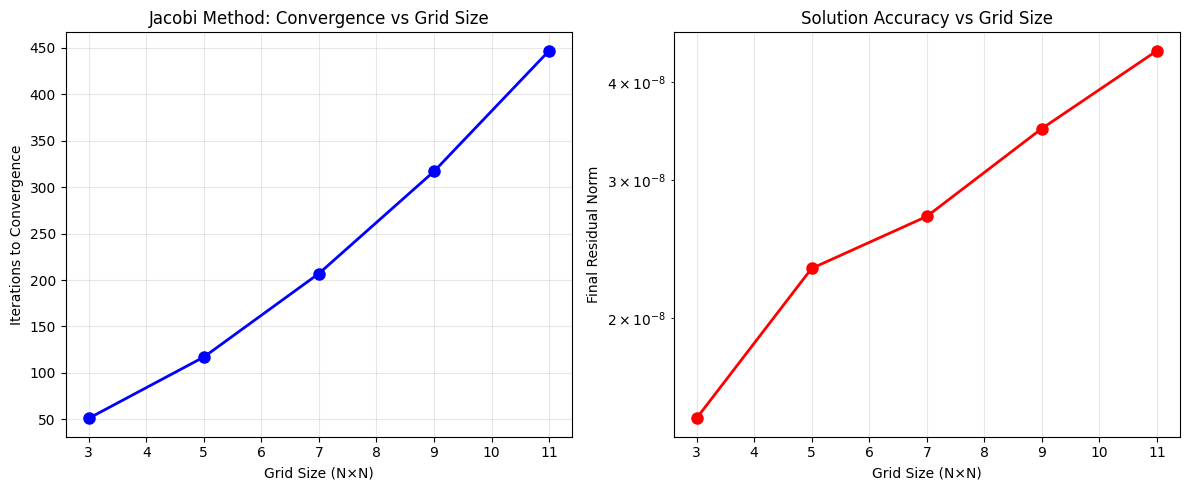


Summary:
  Average iterations per matrix element: 4.44
  Best residual achieved: 1.49e-08
  Worst residual achieved: 4.39e-08


In [8]:
# Analysis: Compare Jacobi iteration performance vs matrix size
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("PERFORMANCE ANALYSIS")
print("="*60)

sizes = []
iterations = []
residuals = []

for n in range(3, 12, 2):  # Test sizes 3, 5, 7, 9, 11
    print(f"\nAnalyzing {n}x{n} grid:")
    
    A = poisson_2d(n)
    x = np.zeros(n**2)
    b = q6(n)
    eps = 1e-8
    
    # Count iterations manually
    iteration = 0
    x = np.array(x, dtype=float)
    b = np.array(b, dtype=float)
    a_zero_mat = []
    d = []
    split(a_zero_mat, d, A)
    
    max_iter = 2000
    while iteration < max_iter and not check_error(x, b, eps, a_zero_mat, d):
        A0x = a_zero_x(x, a_zero_mat)
        b_minus_A0x = b - A0x
        x = d_inv_x(b_minus_A0x, d)
        iteration += 1
    
    final_residual = np.linalg.norm(A @ x - b)
    
    sizes.append(n)
    iterations.append(iteration)
    residuals.append(final_residual)
    
    print(f"  Iterations: {iteration}")
    print(f"  Final residual: {final_residual:.2e}")
    print(f"  Matrix size: {n**2}x{n**2}")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(sizes, iterations, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Grid Size (N×N)')
ax1.set_ylabel('Iterations to Convergence')
ax1.set_title('Jacobi Method: Convergence vs Grid Size')
ax1.grid(True, alpha=0.3)

ax2.semilogy(sizes, residuals, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Grid Size (N×N)')
ax2.set_ylabel('Final Residual Norm')
ax2.set_title('Solution Accuracy vs Grid Size')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"  Average iterations per matrix element: {np.mean([it/(n**2) for it, n in zip(iterations, sizes)]):.2f}")
print(f"  Best residual achieved: {min(residuals):.2e}")
print(f"  Worst residual achieved: {max(residuals):.2e}")